# Classification of brain tumors

### Context

This Jupyter Notebook focuses on brain tumor classification and seeks to optimize the accuracy of inferences. To achieve this, benchmarking was carried out that includes the evaluation of custom models, as well as pre-trained models in PyTorch. 

These pre-trained models were improved using fine-tuning and transfer learning techniques. The main objective is to obtain the greatest number of correct answers in the classification of brain tumors, which can be crucial in medical applications and precise diagnoses.

### Libraries and Variables

In [14]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from collections import Counter
import wandb
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [2]:
BATCH_SIZE = 32
NUM_CLASSES = 3

### Monitoring the model

We use Wandb for detailed monitoring and visualization of our models' training process, allowing us to track metrics, loss, and other training statistics in a user-friendly and interactive manner.

In [ ]:
wandb.login()

In [ ]:
wandb.init(project='Name of your project', name='Name of the run')

### Use of the GPU

In [3]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

In [4]:
device = get_device()
print(f"Using {device} device")

Using cuda device


### Data Loading

The dataset for this project was obtained from the following source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset. 

**However, the class 'notumor' was removed from the dataset as the focus of this project is specifically on classifying different types of brain tumors.**

In [7]:
data_dir = "Your data directory"

In [8]:
transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),           # For training and validation sets
    transforms.RandomRotation(10),])

transform2 = transforms.Compose([
    transforms.Resize((224, 224)),               # For test set
    transforms.ToTensor(),])

### Training, validation and test sets

The `separate_train_val()` function divides the training set (`train_dataset`) into two parts: one for training and one for validation. The `percentage_val` parameter determines the proportion of data assigned to validation.

In [9]:
def separate_train_val(train_dataset, val_percentaje):
    train_size = int(1-val_percentaje * len(train_dataset))
    validation_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])
    return train_dataset, validation_dataset

In [10]:
train_dataset = ImageFolder(root=data_dir + "/training", transform=transform1)
train_dataset, validation_dataset = separate_train_val(train_dataset, 0.2)
test_dataset = ImageFolder(root=data_dir + "/test", transform=transform2)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Class compensation

Before proceeding to create a model, one must check whether the data is balanced or not.

In [12]:
def count_class_samples(dataset, dataset_name):
    labels = [label for _, label in dataset]
    class_counts = dict(Counter(labels))

    print(f"Number of samples per class in the set {dataset_name}:")
    for class_label, count in class_counts.items():
        print(f"Class {class_label}: {count} samples")

In [13]:
count_class_samples(train_dataset, "train")
count_class_samples(test_dataset, "test")
count_class_samples(validation_dataset, "validation")

Number of samples per class in the set train:
Class 0: 1013 samples
Class 2: 674 samples
Class 1: 520 samples
Number of samples per class in the set test:
Class 0: 143 samples
Class 1: 71 samples
Class 2: 93 samples
Number of samples per class in the set val:
Class 0: 270 samples
Class 1: 117 samples
Class 2: 163 samples


As you can see, the classes are quite unbalanced, so later, in the cross entropy function, we will assign weights to each class.

### Visualization

A selection of images of different classes should be displayed with their corresponding labels to facilitate understanding and visualization of the data.

In [12]:
def show_class_images(images, labels, class_names, axes):
    class_images = {}
    for i, ax in enumerate(axes):
        for j in range(len(images)):
            if class_names[labels[j]] not in class_images:
                ax.imshow(images[j])
                ax.set_title(f'Label: {class_names[labels[j]]}')
                ax.axis('off')
                class_images[class_names[labels[j]]] = j
                break

In [13]:
def process_and_show_images(images, labels, train_dataset):
    images = images.permute(0, 2, 3, 1)
    num_images = len(images)
    class_names = train_dataset.dataset.classes

    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 15))
    show_class_images(images, labels, class_names, axes)
    plt.tight_layout()
    plt.show()

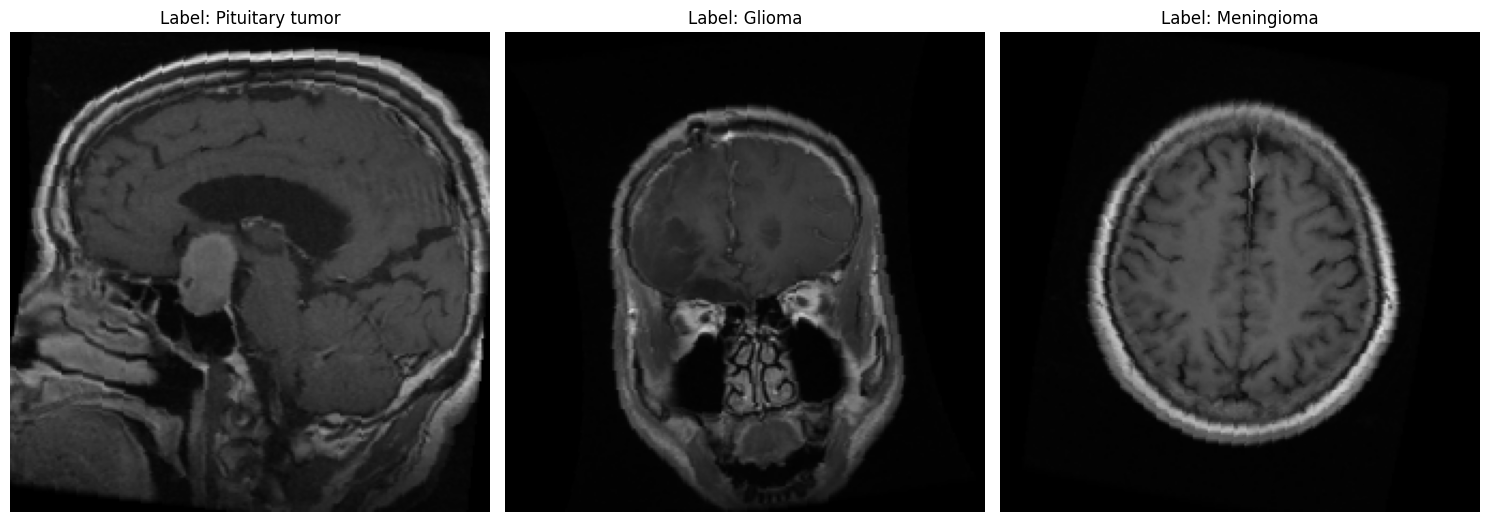

In [19]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
process_and_show_images(images, labels, train_dataset)

### Model

For the model, multiple options were tested, the summary of which can be seen in the *README.md* of the project. On this occasion, the best model obtained is left, which was a ResNet18 model trained from scratch.

In [54]:
class TumorClassifierResNet18(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifierResNet18, self).__init__()

        # Load the pretrained ResNet-18 model
        weights = ResNet18_Weights.DEFAULT
        resnet = resnet18(weights=weights)

        # Freeze all convolutional layers
        for param in resnet.parameters():
            param.requires_grad = True

        # Modify the classification layer (fully connected)
        num_features = resnet.classifier[6].in_features
        resnet.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(256, num_classes)
        )

        self.model = resnet

    def forward(self, x):
        return self.model(x)

In [55]:
model = TumorClassifierResNet18(num_classes=3).to(device)

### Weights per class

To calculate the weights of each class of the dataset, the `count_class_sample()` function generates a dictionary with these values for the total data set (test and train).

In [56]:
def count_class_samples(train_dataset, test_dataset):
    total_samples = len(train_dataset) + len(test_dataset)
    
    class_counts = {}
    
    for _, label in train_dataset.samples:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    
    for _, label in test_dataset.samples:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

    return class_counts, total_samples

In [40]:
class_counts, total_samples = count_class_samples(ImageFolder(root=data_dir + "/training", transform=transform1), ImageFolder(root=data_dir + "/test", transform=transform2) )

### Model Hyper-Parameters

Class weights are then calculated to address class imbalance in a classification problem. Weights are used to adjust the relative importance of classes during training of a model, giving more weight to minority classes.

**ReduceOnPlateau()**

Creates a learning rate scheduler to be used during training of a machine learning model to adjust the learning rate based on a specific metric. The programmer will reduce the learning rate if the metric does not improve after a certain number of epochs.

In [57]:
class_weights = torch.Tensor([total_samples / (NUM_CLASSES * class_counts[i]) for i in range(NUM_CLASSES)]).to(device)
criterion = criterion = nn.CrossEntropyLoss(weight=class_weights)

initial_lr = 3e-4 
optimizer = torch.optim.Adam(model.parameters(), lr = initial_lr)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)  

### Save metrics to wandb

In [ ]:
config = wandb.config
config.learning_rate = '3e-4 (ReduceLROnPlateau)'
config.batch_size = BATCH_SIZE
config.regularization = '-'
config.optimizer = 'Adam'
config.criterion = 'CrossEntropy'
config.act_func = 'ReLU'
config.class_compensation = 'Weighted Cross-Entropy'

### Training and validation

* `train()`: Starts the model training process for a specific number of epochs (`num_epochs`). During each epoch, a training and validation cycle is performed. Training and validation metrics are recorded, and the model is updated if better performance is obtained. Additionally, the learning rate is adjusted using a learning rate scheduler (`lr_scheduler`).
* `early_stopping():` Controls whether to stop training prematurely if validation accuracy does not improve for a specified number of epochs (`patience`). Returns True if the early stopping criterion is met, otherwise it returns False.
* `train_epoch()`: Performs a training cycle in a single epoch. Calculates loss and training metrics such as precision, weighted precision, weighted recall, and F1 value.
* `validate_epoch()`: Performs a validation loop in a single epoch. Calculates loss and validation metrics, including precision, weighted precision, weighted recall, and F1 value.
* `get_metrics()`: Calculates metrics such as precision, weighted precision, weighted recall, and F1 value from true and predicted labels.
* `log_metrics()`: Logs the training and validation metrics to a logging system, such as Weights & Biases (Wandb), using the provided metrics and the epoch number as passed.

In [59]:
class Trainer:
    def __init__(self, model, device, train_loader, validation_loader, optimizer, criterion, num_epochs=20, patience=5, lr_scheduler=None):
        self.model = model
        self.device = device
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.patience = patience  # Number of epochs to wait for improvement
        self.best_val_accuracy = 0.0
        self.early_stopping_counter = 0
        self.lr_scheduler = lr_scheduler


    def train(self):
        for epoch in range(self.num_epochs):
            train_loss, train_accuracy, train_metrics = self.train_epoch()
            val_loss, val_accuracy, val_metrics = self.validate_epoch()

            self.log_metrics(epoch, train_loss, train_accuracy, train_metrics, val_loss, val_accuracy, val_metrics)
            self.print_epoch_summary(epoch, train_loss, train_accuracy, val_loss, val_accuracy)

            if self.early_stopping(val_accuracy):
                print(f'Validation accuracy did not improve for {self.patience} epochs. Stopping early.')
                break

            self.lr_scheduler.step(val_loss) # Update learning rate based on validation loss

            self.save_best_model(val_accuracy)

    def early_stopping(self, val_accuracy):
        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1

        return self.early_stopping_counter >= self.patience

    def train_epoch(self):
        self.model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(self.train_loader):
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy, train_precision, train_recall, train_f1 = self.get_metrics(labels.cpu().numpy(), predicted.cpu().numpy(), total, correct)

        return train_loss, train_accuracy, {'precision': train_precision, 'recall': train_recall, 'f1': train_f1}

    def validate_epoch(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.validation_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy, val_precision, val_recall, val_f1 = self.get_metrics(labels.cpu().numpy(), predicted.cpu().numpy(), total, correct)

        return val_loss, val_accuracy, {'precision': val_precision, 'recall': val_recall, 'f1': val_f1}

    def get_metrics(self, true_labels, predicted_labels, total, correct):
        accuracy = correct / total
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels, average='weighted')

        return accuracy, precision, recall, f1

    def log_metrics(self, epoch, train_loss, train_accuracy, train_metrics, val_loss, val_accuracy, val_metrics):
        wandb.log({
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "train_precision": train_metrics['precision'],
            "train_recall": train_metrics['recall'],
            "train_f1": train_metrics['f1'],
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "val_precision": val_metrics['precision'],
            "val_recall": val_metrics['recall'],
            "val_f1": val_metrics['f1']
        }, step=epoch)

    def print_epoch_summary(self, epoch, train_loss, train_accuracy, val_loss, val_accuracy):
        print(f'Epoch [{epoch+1}/{self.num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')

    def save_best_model(self, val_accuracy):
        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            torch.save(self.model.state_dict(), 'best_model.pth')


In [60]:
trainer = Trainer(model, device, train_loader, validation_loader, optimizer, criterion, 30, 20, lr_scheduler=lr_scheduler)
trainer.train()

Epoch [1/30], Training Loss: 46.0847, Training Accuracy: 69.69%, Validation Loss: 12.0155, Validation Accuracy: 77.27%
Epoch [2/30], Training Loss: 28.5519, Training Accuracy: 83.28%, Validation Loss: 8.3336, Validation Accuracy: 77.64%
Epoch [3/30], Training Loss: 26.6641, Training Accuracy: 84.37%, Validation Loss: 5.3916, Validation Accuracy: 84.73%
Epoch [4/30], Training Loss: 21.2677, Training Accuracy: 86.00%, Validation Loss: 5.2368, Validation Accuracy: 84.18%
Epoch [5/30], Training Loss: 17.6853, Training Accuracy: 88.99%, Validation Loss: 4.4799, Validation Accuracy: 90.91%
Epoch [6/30], Training Loss: 16.4715, Training Accuracy: 90.98%, Validation Loss: 5.4623, Validation Accuracy: 87.64%
Epoch [7/30], Training Loss: 15.1452, Training Accuracy: 90.67%, Validation Loss: 5.0990, Validation Accuracy: 91.64%
Epoch [8/30], Training Loss: 15.4569, Training Accuracy: 91.57%, Validation Loss: 5.0151, Validation Accuracy: 89.45%
Epoch [9/30], Training Loss: 12.0083, Training Accuracy

### Test

* `evaluate_model_on_test()`: This method evaluates the model on a test data set (`test_loader`). Calculates the loss on the test set and evaluation metrics such as precision. Additionally, it saves the true and predicted labels. Returns the true labels, predicted labels, and loss on the test set.
* `calculate_metrics()`: This method calculates evaluation metrics, including precision, weighted precision, weighted recall, and F1 value, from the true labels and predicted labels in the test set.
* `log_metrics_to_wandb()`: This method logs evaluation metrics to a logging system, such as Weights & Biases (Wandb), using the provided metrics.

In [61]:
class Evaluator:
    def __init__(self, model, criterion):
        self.model = model
        self.criterion = criterion

    def evaluate_model_on_test(self, test_loader, device):
        self.model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())

        return all_labels, all_predicted, test_loss

    def calculate_metrics(self, all_labels, all_predicted):
        test_accuracy = sum(1 for x, y in zip(all_labels, all_predicted) if x == y) / len(all_labels)
        test_precision = precision_score(all_labels, all_predicted, average='weighted')
        test_recall = recall_score(all_labels, all_predicted, average='weighted')
        test_f1_score = f1_score(all_labels, all_predicted, average='weighted')

        return test_accuracy, test_f1_score, test_precision, test_recall

    def log_metrics_to_wandb(self, test_accuracy, test_f1_score, test_precision, test_recall):
        wandb.log({
            'test_accuracy': test_accuracy,
            'test_f1_score': test_f1_score,
            'test_precision': test_precision,
            'test_recall': test_recall
        })

In [62]:
evaluator = Evaluator(model, criterion)
all_labels, all_predicted, test_loss = evaluator.evaluate_model_on_test(test_loader, device)
test_accuracy, test_f1_score, test_precision, test_recall = evaluator.calculate_metrics(all_labels, all_predicted)
evaluator.log_metrics_to_wandb(test_accuracy, test_f1_score, test_precision, test_recall)

### Confusion matrix

The confusion matrix is an essential tool for evaluating and understanding the performance of classification models. It provides detailed information about the behavior of the model and is crucial in making decisions related to the improvement and optimization of the models.

In [63]:
class_names = test_dataset.classes

['Glioma', 'Meningioma', 'Pituitary tumor']


In [65]:
class ConfusionMatrix:
    def __init__(self, class_names):
        self.class_names = class_names
        self.cm = None

    def create_matrix(self, all_labels, all_predicted):
        self.cm = confusion_matrix(all_labels, all_predicted)

    def show_matrix(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        heatmap = sns.heatmap(self.cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

        ax.set_ylabel("Actual Labels")
        ax.set_xlabel("Predicted Labels")
        ax.set_title("Confusion Matrix")
        heatmap.set_xticklabels(self.class_names)
        heatmap.set_yticklabels(self.class_names, rotation=0)
        plt.show()

    def log_matrix(self):
        if self.cm is not None:
            fig, ax = plt.subplots(figsize=(8, 8))
            heatmap = sns.heatmap(self.cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

            ax.set_ylabel("Actual Labels")
            ax.set_xlabel("Predicted Labels")
            ax.set_title("Confusion Matrix")
            heatmap.set_xticklabels(self.class_names)
            heatmap.set_yticklabels(self.class_names, rotation=0)
            wandb.log({"Confusion_matrix": wandb.Image(fig, caption="Confusion Matrix")})
        else:
            print("Confusion matrix has not been created yet.")

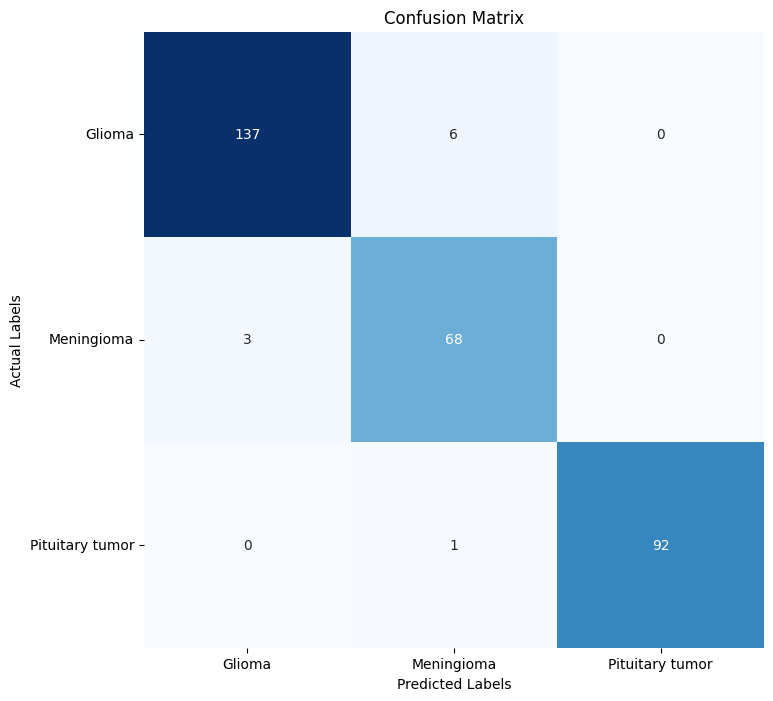

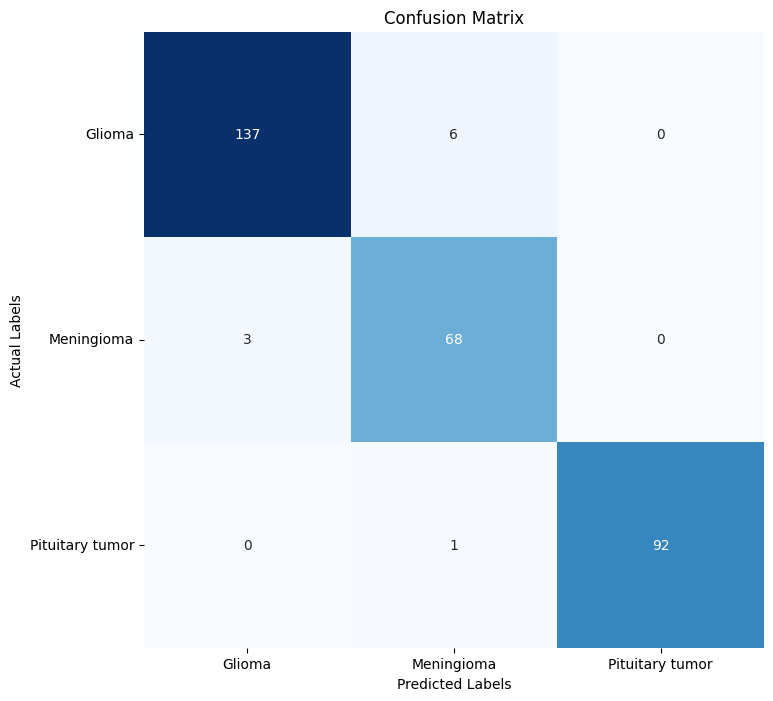

In [66]:
class_names = ['Glioma', 'Meningioma', 'Pituitary tumor']
confusion_matrix_obj = ConfusionMatrix(class_names)
confusion_matrix_obj.create_matrix(all_labels, all_predicted)
confusion_matrix_obj.show_matrix()
confusion_matrix_obj.log_matrix()

### Close WanDB conection

In [67]:
wandb.log_artifact('route to the best saved model', name='model', type='model') 

In [68]:
wandb.finish()

test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
train_f1,▂▂▇▄▆▁▃█▇▄▆▇▃█▇▇█▆▇████████▇██
train_loss,█▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_precision,▁▁▇▄▆▁▃█▇▄▆▇▄█▇▇█▆▇████████▇██
train_recall,▁▂▇▄▆▁▃█▇▄▆▇▃█▇▇█▆▇████████▇██
val_accuracy,▁▁▄▃▆▅▆▅▇▇▄▇▆▇▇▇▇▆█▇▇█▇▇▇▇▇██▇
val_f1,▄▁▃▃▆▄█▆██▃█▆█▄█▆▆█▆▆▆▄▆▄▃▆▆▆▆
